<a href="https://colab.research.google.com/github/FourLevel/Fubon_2024/blob/main/%E5%AF%8C%E9%82%A6%E5%9B%9E%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 計算個股權重，建構投資組合

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  6 of 6 completed


大盤期間報酬率：31.93%

最佳化權重：
1726.TW: 35.74%
2474.TW: 21.48%
3171.TWO: 13.29%
4958.TW: 10.00%
8103.TW: 19.49%

預期投資組合報酬：18.68%
預期投資組合波動率：0.1583

投資組合個股年化平均報酬：
Ticker
1726.TW      7.02%
2474.TW     20.45%
3171.TWO     24.8%
4958.TW     23.01%
8103.TW     30.83%
^TWII        37.0%
dtype: object



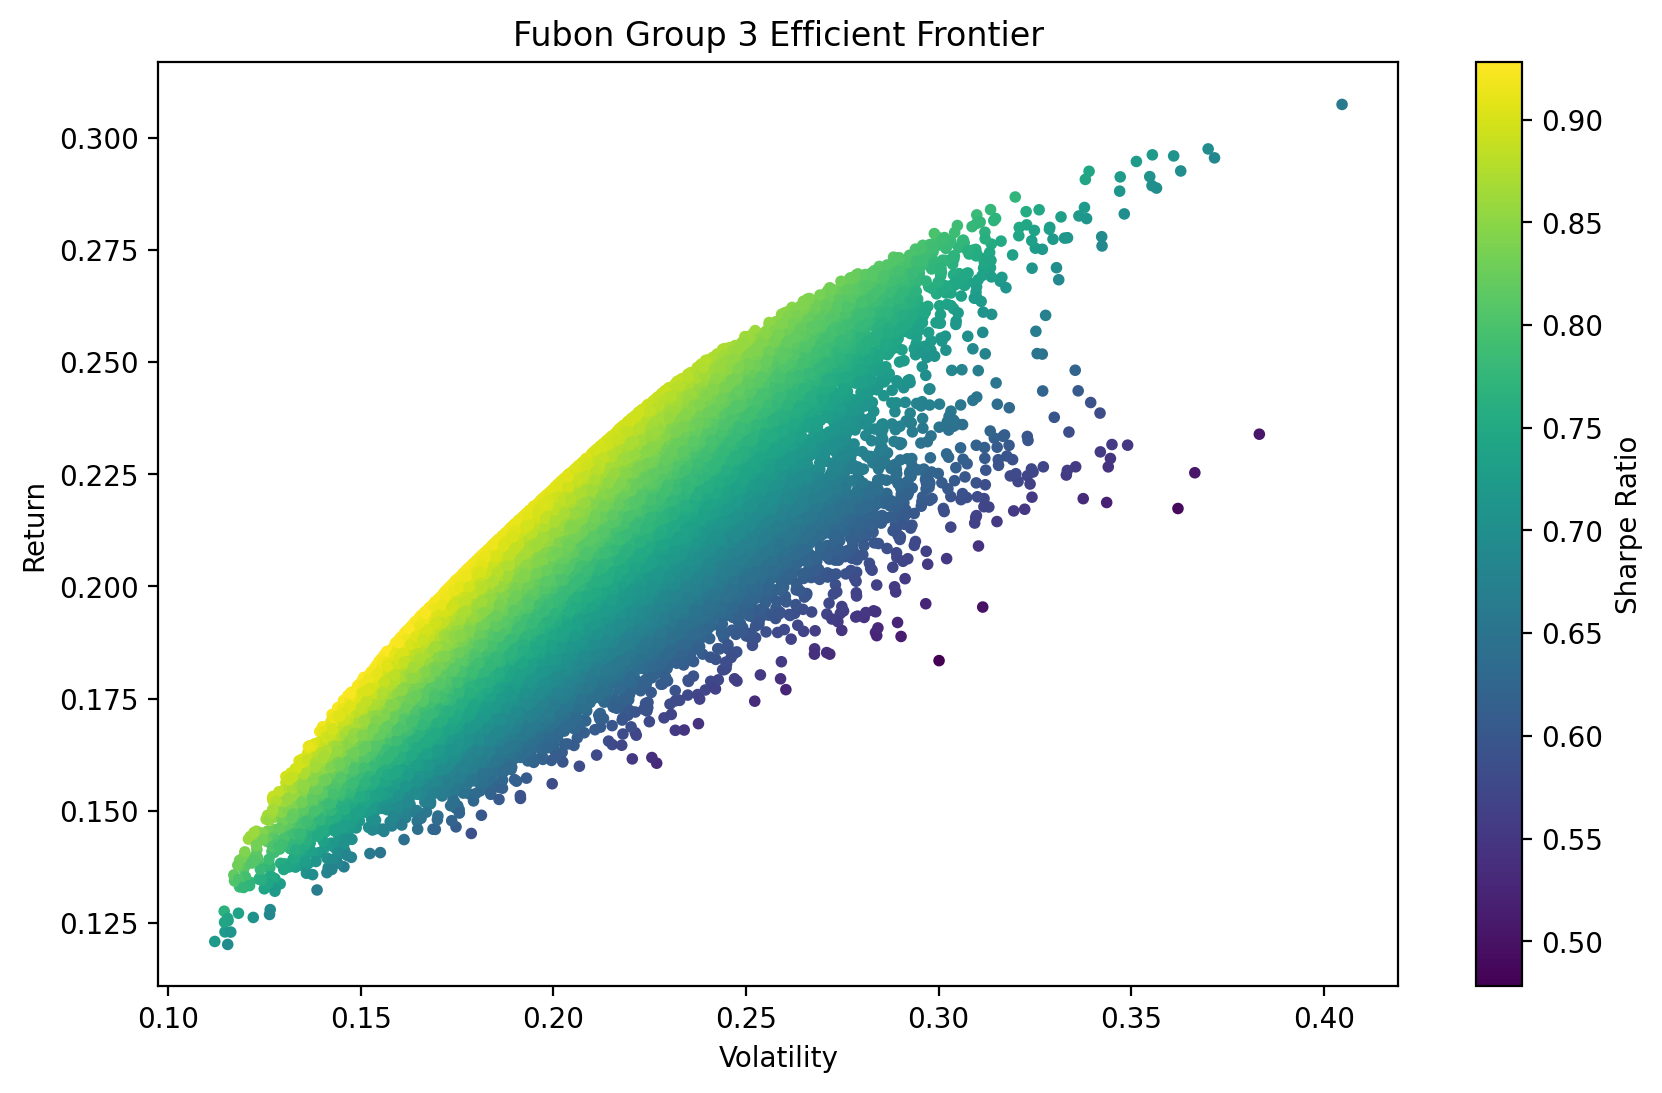

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 下載五檔股票的歷史數據
# 1726 永記、2474 可成、3171 炎洲流通、4958 臻鼎、8103 瀚荃
stocks = ['1726.TW', '2474.TW', '3171.TWO', '4958.TW', '8103.TW']
stocks_2 = ['1726.TW', '2474.TW', '3171.TWO', '4958.TW', '8103.TW','^TWII']
start_date = '2024-01-01'
end_date = '2024-11-09'

# 從 yfinance 下載股票調整後收盤價
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
data_2 = yf.download(stocks_2, start=start_date, end=end_date)['Adj Close']

# 計算日報酬率
returns = data.pct_change(fill_method=None).dropna()
returns_2 = data_2.pct_change(fill_method=None).dropna()

# 計算期間大盤報酬率
TWII_return = (data_2['^TWII'].loc['2024-11-08'] - data_2['^TWII'].loc['2024-01-02']) / data_2['^TWII'].loc['2024-01-02']
print(f'大盤期間報酬率：{TWII_return * 100:.2f}%\n') 

# 計算每檔股票的年化平均報酬和共變異數矩陣
mean_returns = returns.mean() * 252  # 年化
mean_returns_2 = returns_2.mean() * 252  # 年化
cov_matrix = returns.cov() * 252  # 年化共變異數矩陣
cov_matrix_2 = returns_2.cov() * 252  # 年化共變異數矩陣

# 計算夏普比率 Sharpe Ratio，假設無風險利率為 0.04
risk_free_rate = 0.04
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.04):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility  # 最小化負的夏普比率

# 目標：最大化夏普比率；約束條件：權重總和為 1，且每個權重大於 0.1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # 權重總和為 1
bounds = [(0.1, 1) for _ in range(len(stocks))]  # 每檔股票的權重在 0.1 和 1 之間

# 初始權重：均等分配
initial_weights = [1.0 / len(stocks)] * len(stocks)

# 使用最小化方法進行優化
opt_result = minimize(sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# 優化後的權重
optimal_weights = opt_result.x

# 顯示結果
# 將優化後的權重格式化為四位小數，並轉換回浮點數
print('最佳化權重：')
formatted_optimal_weights = [float(f'{elem:.4f}') for elem in optimal_weights]
for stock, weight in zip(stocks, formatted_optimal_weights):
    print(f'{stock}: {weight * 100:.2f}%')
print()
print(f'預期投資組合報酬：{np.sum(optimal_weights * mean_returns) * 100:.2f}%')
print(f'預期投資組合波動率：{np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))):.4f}')
print()
# 顯示投資組合個股的年化平均報酬和共變異數矩陣
print('投資組合個股年化平均報酬：')
mean_returns_2_percent = mean_returns_2 * 100
print(mean_returns_2_percent.round(2).astype(str) + '%')
print()
# print('股票共變異數矩陣（年化）：')
# print(cov_matrix_2)

# 繪製效率前緣
# 生成 1000000 個隨機投資組合，計算每個投資組合的報酬率和波動率，並繪製效率前緣
num_portfolios = 100000  # 生成隨機投資組合的數量
results = np.zeros((3, num_portfolios))  # 初始化結果矩陣

for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = (portfolio_return - 0.04) / portfolio_volatility  # 夏普比率

# 繪製圖表
plt.figure(figsize=(10, 6), dpi=200)
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Fubon Group 3 Efficient Frontier')
plt.show()

# 繪製效率前緣、CML 及預期投組

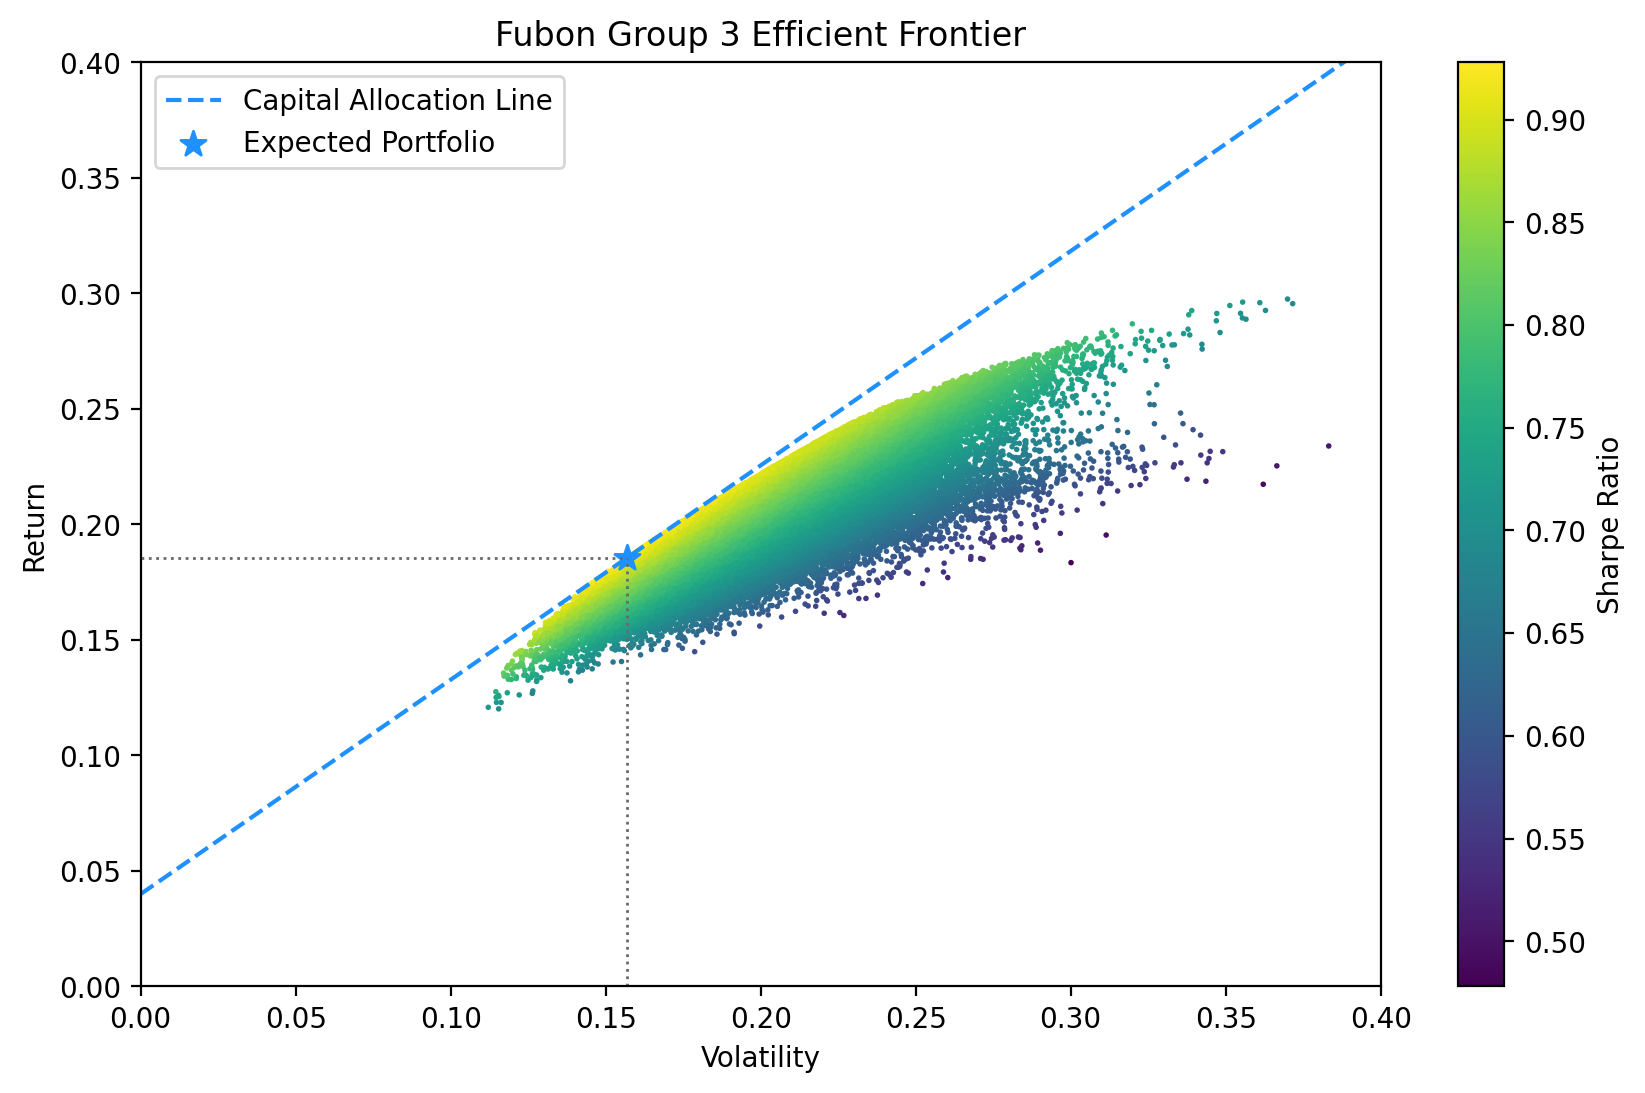

In [3]:
# 找到夏普比率最高的投資組合
max_sharpe_idx = np.argmax(results[2,:])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]

# 繪製效率前緣
plt.figure(figsize=(10, 6), dpi=200)
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', s=1)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Fubon Group 3 Efficient Frontier')

# 繪製資本市場線
x = np.linspace(0, max(results[1,:]), 100)
y = risk_free_rate + (max_sharpe_return - risk_free_rate) / max_sharpe_volatility * x
plt.plot(x, y, color='DodgerBlue', linestyle='--',linewidth=1.5, label='Capital Allocation Line')
plt.legend(loc='upper left')

# 標記夏普比率最高的投資組合
plt.scatter(max_sharpe_volatility, max_sharpe_return, color='DodgerBlue', marker='*', s=90, label='Expected Portfolio')

# 從星號標記延伸虛線到 x 軸與 y 軸
plt.plot([max_sharpe_volatility, max_sharpe_volatility], [0, max_sharpe_return], color='DimGray', linestyle='dotted',linewidth=1)
plt.plot([0, max_sharpe_volatility], [max_sharpe_return, max_sharpe_return], color='DimGray', linestyle='dotted',linewidth=1)

# 設定座標軸範圍
plt.xlim(0, 0.40)
plt.ylim(0, 0.40)

# 設定圖例
plt.legend()
plt.show()

# 計算投資組合績效與相關績效評估指標

[*********************100%***********************]  5 of 5 completed

個股投資期間與大盤共變異數：
Ticker
1726.TW     0.000044
2474.TW     0.000072
3171.TWO    0.000079
4958.TW     0.000140
8103.TW     0.000118
^TWII       0.000186
Name: ^TWII, dtype: float64

個股投資期間 beta:
1726 永記 beta: 0.2342
2474 可成 beta: 0.3876
3171 炎洲流通 beta: 0.4262
4958 臻鼎-KY beta: 0.7529
8103 瀚荃 beta: 0.6333

年化大盤波動率：0.2165

市場報酬：
期間市場報酬：31.93%
年化市場報酬：37.00%
年化市場溢酬：27.93%

投組 beta: 0.4199
投組 Treynor Ratio: 0.3337
投組 Jensen's Alpha: 0.0229
投組 sharpe ratio: 0.8416
市場 sharpe ratio: 1.5246
M-squared: -0.1478


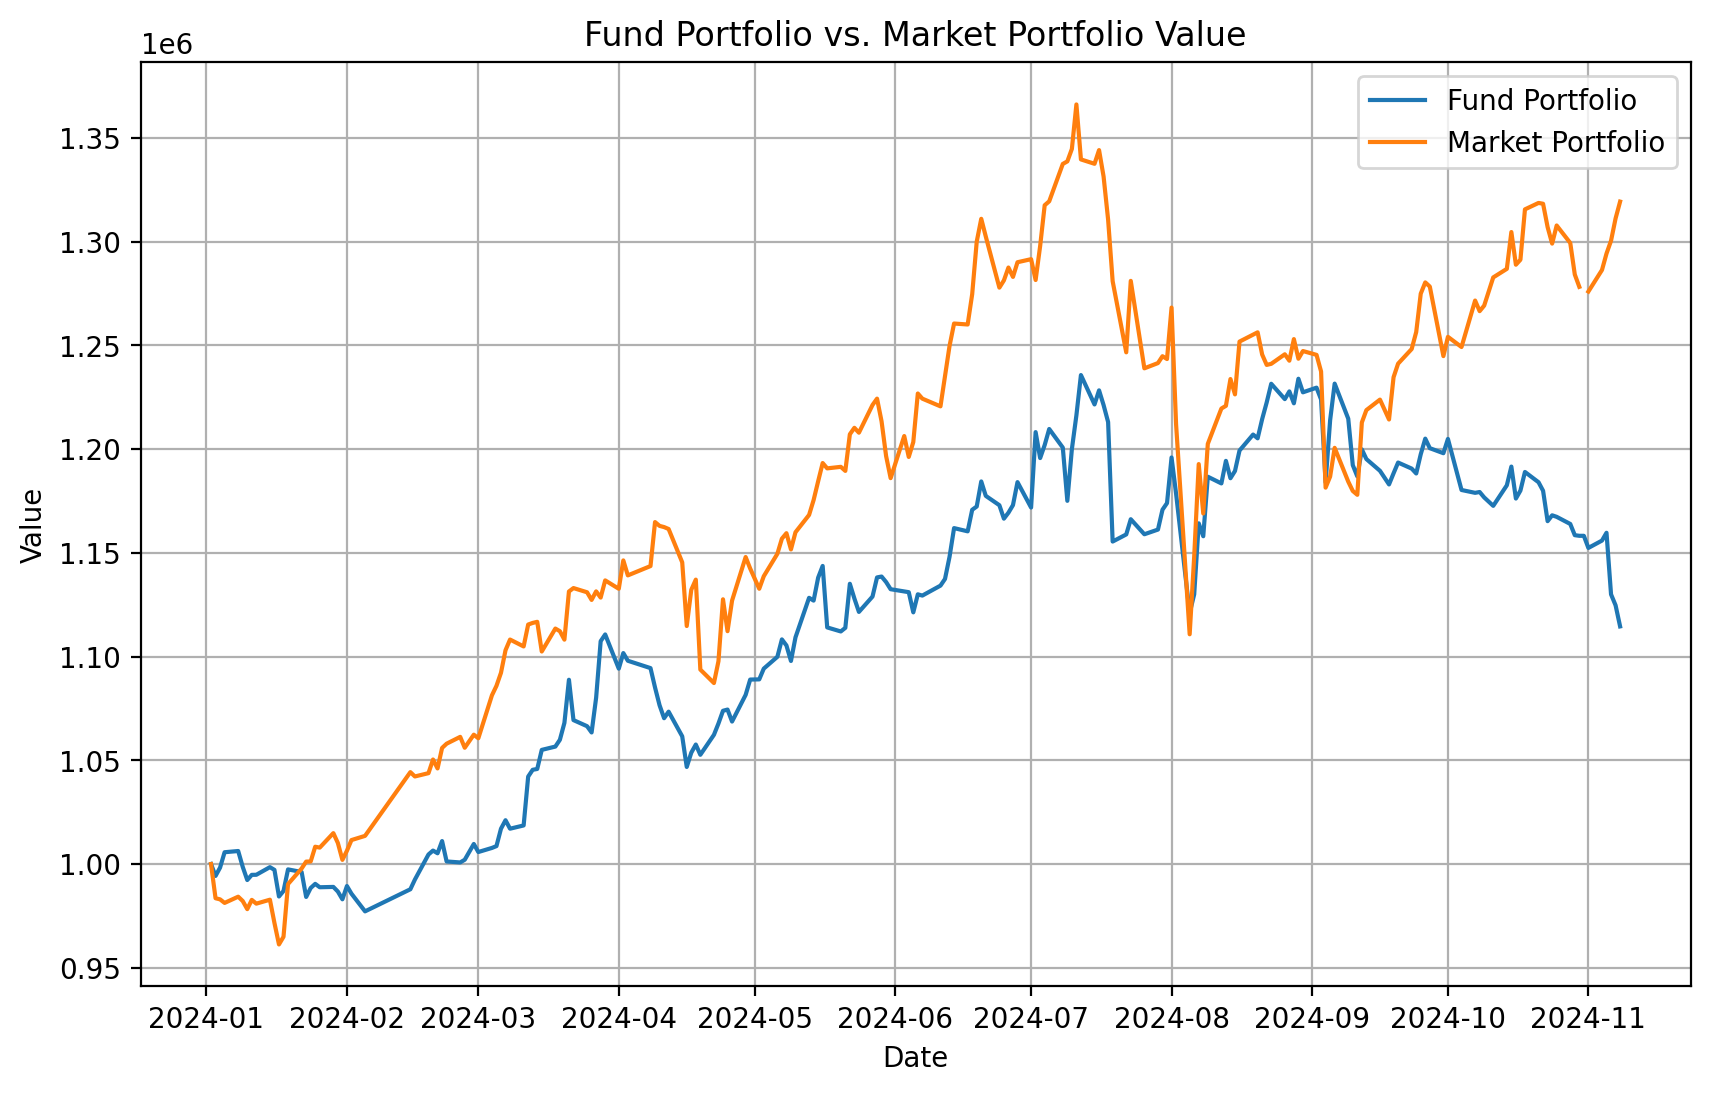

In [37]:
#  計算投組/個股投資期間共變異數
covariances_with_twii = returns_2.cov()['^TWII']
print('個股投資期間與大盤共變異數：')
print(covariances_with_twii)
print()

#  計算投組/個股投資期間 beta
beta_1726 = covariances_with_twii['1726.TW'] / covariances_with_twii['^TWII']
beta_2474 = covariances_with_twii['2474.TW'] / covariances_with_twii['^TWII']
beta_3171 = covariances_with_twii['3171.TWO'] / covariances_with_twii['^TWII']
beta_4958 = covariances_with_twii['4958.TW'] / covariances_with_twii['^TWII']
beta_8103 = covariances_with_twii['8103.TW'] / covariances_with_twii['^TWII']

# 顯示個股投資期間 beta
print('個股投資期間 beta:')
print(f'1726 永記 beta: {beta_1726:.4f}')
print(f'2474 可成 beta: {beta_2474:.4f}')
print(f'3171 炎洲流通 beta: {beta_3171:.4f}')
print(f'4958 臻鼎-KY beta: {beta_4958:.4f}')
print(f'8103 瀚荃 beta: {beta_8103:.4f}')
print()

# 市場波動率
TWII_volatility = data_2['^TWII'].pct_change(fill_method=None).dropna().std() * np.sqrt(252)
print(f'年化大盤波動率：{TWII_volatility:.4f}')
print()

#市場溢酬
market_premium = TWII_return - risk_free_rate
market_return_annualized = returns_2['^TWII'].mean() * 252  # 計算年化市場報酬

# 顯示市場報酬
print('市場報酬：')
print(f'期間市場報酬：{TWII_return * 100:.2f}%')
print(f'年化市場報酬：{market_return_annualized * 100:.2f}%')
print(f'年化市場溢酬：{market_premium * 100:.2f}%')
print()

# 計算投組 beta
portfolio_beta = np.sum(optimal_weights * [beta_1726, beta_2474, beta_3171, beta_4958, beta_8103])
print(f'投組 beta: {portfolio_beta:.4f}')

# 計算 Treynor Ratio
treynor_ratio = (portfolio_return - 0.04) / portfolio_beta
print(f'投組 Treynor Ratio: {treynor_ratio:.4f}')

# 計算 Jensen's Alpha
jensen_alpha = portfolio_return - (0.04 + portfolio_beta * (TWII_return - 0.04))
print(f'投組 Jensen\'s Alpha: {jensen_alpha:.4f}')

# 計算投組報酬和波動率
portfolio_return = np.sum(optimal_weights * mean_returns)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, weights)))

# 計算 sharpe ratio
portfolio_sharpe_ratio = (portfolio_return - 0.04) / portfolio_volatility
benchmark_sharpe_ratio = (mean_returns_2['^TWII'] - 0.04) / TWII_volatility

# 計算 m-squared
m_squared = (portfolio_sharpe_ratio - benchmark_sharpe_ratio) * TWII_volatility

# 顯示 sharpe ratio
print(f'投組 sharpe ratio: {portfolio_sharpe_ratio:.4f}')
print(f'市場 sharpe ratio: {benchmark_sharpe_ratio:.4f}')
print(f'M-squared: {m_squared:.4f}')

'''
#  匯出至excel
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# AFTER your code that generates the values, create the DataFrame:
data = {
    '項目': ['永記beta', '可成beta', '炎洲流通beta', '臻鼎-KYbeta', '瀚荃beta', '大盤波動率', '市場溢酬', '投組beta', 'Treynor Ratio', "Jensen's Alpha", 'sharpe ratio', 'benchmark sharpe ratio', 'M-squared'],
    '數值': [0.2340, 0.3968, 0.4284, 0.7440, 0.6334, 0.2163, 0.2604, 0.4389, 0.4742, 0.0938, 0.8845, 1.4327, -0.1186
           ]}
df = pd.DataFrame(data)  # <- Define df before using it

df.to_excel('回測指標.xlsx', index=False)  # 請將 '你的 Excel 文件名稱' 替換為實際的文件名稱
'''

# 繪製投資組合與大盤每日淨值
# 假設起始投資金額為一百萬
initial_investment = 1_000_000

# 將 optimal_weights 轉換成 NumPy 陣列
optimal_weights = np.array(optimal_weights)

# 用 stock_prices 來代表從 yfinance 下載的股票價格資料
stock_prices = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# 確認 stock_prices 的列名和 optimal_weights 的順序一致
assert stock_prices.columns.tolist() == stocks, 'data 的列名和 optimal_weights 的順序不一致'

# 使用 stock_prices.values 提取 data 的 NumPy 陣列表示形式
portfolio_value = (stock_prices.values * optimal_weights).sum(axis=1) * initial_investment / (stock_prices.iloc[0].values * optimal_weights).sum()

# 計算市場投資組合每日價值
market_value = data_2['^TWII'] * initial_investment / data_2['^TWII'].iloc[0]

# 建立DataFrame
portfolio_df = pd.DataFrame({'投資組合淨值': portfolio_value, '大盤淨值': market_value})

# 繪製圖表
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(portfolio_df.index, portfolio_df['投資組合淨值'], label='Fund Portfolio')
plt.plot(portfolio_df.index, portfolio_df['大盤淨值'], label='Market Portfolio')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Fund Portfolio vs. Market Portfolio Value')
plt.legend()
plt.grid(True)  # 添加網格
plt.show()


# Clean Code Version, 跟上面的內容一樣，只是優化 code 寫法
## 計算個股權重，建構投資組合

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 下載股票資料
# 1726 永記、2474 可成、3171 炎洲流通、4958 臻鼎、8103 瀚荃
stocks = ['1726.TW', '2474.TW', '3171.TWO', '4958.TW', '8103.TW']
stocks_with_index = stocks + ['^TWII']
start_date = '2024-01-01'
end_date = '2024-11-09'

# 下載調整後收盤價
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
data_with_index = yf.download(stocks_with_index, start=start_date, end=end_date)['Adj Close']

# 計算報酬率
returns = data.pct_change(fill_method=None).dropna()
returns_with_index = data_with_index.pct_change(fill_method=None).dropna()

# 計算大盤報酬率
twii_return = (data_with_index['^TWII'].iloc[-1] - data_with_index['^TWII'].iloc[0]) / data_with_index['^TWII'].iloc[0]
print(f'大盤期間報酬率：{twii_return * 100:.2f}%\n')

# 計算年化報酬與共變異數
mean_returns = returns.mean() * 252
mean_returns_with_index = returns_with_index.mean() * 252
cov_matrix = returns.cov() * 252
cov_matrix_with_index = returns_with_index.cov() * 252

# 定義夏普比率計算函數
def calculate_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.04):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

# 設定最佳化參數
risk_free_rate = 0.04
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0.1, 1) for _ in range(len(stocks))]
initial_weights = [1.0 / len(stocks)] * len(stocks)

# 最佳化投資組合
opt_result = minimize(
    calculate_sharpe_ratio, 
    initial_weights,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = opt_result.x

# 顯示最佳化結果
print('最佳化權重：')
formatted_weights = [float(f'{w:.4f}') for w in optimal_weights]
for stock, weight in zip(stocks, formatted_weights):
    print(f'{stock}: {weight * 100:.2f}%')
print()

portfolio_return = np.sum(optimal_weights * mean_returns)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

print(f'預期投資組合報酬：{portfolio_return * 100:.2f}%')
print(f'預期投資組合波動率：{portfolio_volatility:.4f}')
print()

print('投資組合個股年化平均報酬：')
mean_returns_percent = mean_returns_with_index * 100
print(mean_returns_percent.round(2).astype(str) + '%')
print()

# 繪製效率前緣
num_portfolios = 100000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility 
    results[2,i] = sharpe

plt.figure(figsize=(10, 6), dpi=200)
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Fubon Group 3 Efficient Frontier')
plt.show()

## 計算投資組合績效與相關績效評估指標

In [ ]:
# 計算投組/個股投資期間共變異數與 beta
covariances_with_twii = returns_2.cov()['^TWII']
print('個股投資期間與大盤共變異數：')
print(covariances_with_twii)
print()

# 計算個股 beta
betas = {}
for stock in stocks:
    betas[stock] = covariances_with_twii[stock] / covariances_with_twii['^TWII']

# 顯示個股 beta
print('個股投資期間 beta:')
for stock in stocks:
    stock_name = {
        '1726.TW': '永記',
        '2474.TW': '可成', 
        '3171.TWO': '炎洲流通',
        '4958.TW': '臻鼎-KY',
        '8103.TW': '瀚荃'
    }[stock]
    print(f'{stock_name} beta: {betas[stock]:.4f}')
print()

# 計算市場指標
TWII_volatility = data_2['^TWII'].pct_change(fill_method=None).dropna().std() * np.sqrt(252)
market_return_annualized = returns_2['^TWII'].mean() * 252
market_premium = TWII_return - risk_free_rate

# 顯示市場指標
print(f'年化大盤波動率：{TWII_volatility:.4f}')
print('市場報酬：')
print(f'期間市場報酬：{TWII_return * 100:.2f}%')
print(f'年化市場報酬：{market_return_annualized * 100:.2f}%')
print(f'年化市場溢酬：{market_premium * 100:.2f}%')
print()

# 計算投資組合績效指標
portfolio_beta = np.sum(optimal_weights * list(betas.values()))
portfolio_return = np.sum(optimal_weights * mean_returns)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, weights)))

treynor_ratio = (portfolio_return - risk_free_rate) / portfolio_beta
jensen_alpha = portfolio_return - (risk_free_rate + portfolio_beta * (TWII_return - risk_free_rate))
portfolio_sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
benchmark_sharpe_ratio = (mean_returns_2['^TWII'] - risk_free_rate) / TWII_volatility
m_squared = (portfolio_sharpe_ratio - benchmark_sharpe_ratio) * TWII_volatility

# 顯示投資組合績效指標
print(f'投組 beta: {portfolio_beta:.4f}')
print(f'投組 Treynor Ratio: {treynor_ratio:.4f}')
print(f"投組 Jensen's Alpha: {jensen_alpha:.4f}")
print(f'投組 sharpe ratio: {portfolio_sharpe_ratio:.4f}')
print(f'市場 sharpe ratio: {benchmark_sharpe_ratio:.4f}')
print(f'M-squared: {m_squared:.4f}')

# 繪製投資組合與大盤每日淨值
initial_investment = 1_000_000

stock_prices = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
assert stock_prices.columns.tolist() == stocks, 'stock_prices 的列名和 optimal_weights 的順序不一致'

portfolio_value = (stock_prices.values * optimal_weights).sum(axis=1) * initial_investment / (stock_prices.iloc[0].values * optimal_weights).sum()
market_value = data_2['^TWII'] * initial_investment / data_2['^TWII'].iloc[0]

portfolio_df = pd.DataFrame({
    '投資組合淨值': portfolio_value, 
    '大盤淨值': market_value
})

plt.figure(figsize=(10, 6), dpi=200)
plt.plot(portfolio_df.index, portfolio_df['投資組合淨值'], label='Fund Portfolio')
plt.plot(portfolio_df.index, portfolio_df['大盤淨值'], label='Market Portfolio')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Fund Portfolio vs. Market Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

'''
#  匯出至excel
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# AFTER your code that generates the values, create the DataFrame:
data = {
    '項目': ['永記beta', '可成beta', '炎洲流通beta', '臻鼎-KYbeta', '瀚荃beta', '大盤波動率', '市場溢酬', '投組beta', 'Treynor Ratio', "Jensen's Alpha", 'sharpe ratio', 'benchmark sharpe ratio', 'M-squared'],
    '數值': [0.2340, 0.3968, 0.4284, 0.7440, 0.6334, 0.2163, 0.2604, 0.4389, 0.4742, 0.0938, 0.8845, 1.4327, -0.1186
           ]}
df = pd.DataFrame(data)  # <- Define df before using it

df.to_excel('回測指標.xlsx', index=False)  # 請將 '你的 Excel 文件名稱' 替換為實際的文件名稱
'''